# IPL Score Predictor - Neural Network Model

This notebook implements a neural network for predicting IPL cricket match scores based on sequence data.

## Setup and Imports

In [415]:
# Uncomment to install required packages
# %pip install pandas numpy torch matplotlib scikit-learn

In [416]:
# Basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# ML imports
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Enable debugging
import logging


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('IPLScorePredictor')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")
if device.type == 'cuda':
    logger.info(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    logger.info(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

2025-05-07 11:05:18,143 - INFO - Using device: cuda
2025-05-07 11:05:18,144 - INFO - CUDA Device: NVIDIA GeForce MX350
2025-05-07 11:05:18,144 - INFO - CUDA Memory Allocated: 20.23 MB


## Helper Functions and Variables Setup

In [417]:
# Variables for device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
team_encoder_global = None

# Define key parameters
total_input_size = 25  # Total size including all features
tf_ratio = 1  # Teacher forcing ratio
tf_decay = 0.2/32  # Teacher forcing decay rate

def load_model_with_config(model_class):
    """Load a saved model and its configuration.
    
    Args:
        model_class: The class of the model to load
        
    Returns:
        Tuple of (loaded model, model configuration)
    """
    try:
        # Add StandardScaler and LabelEncoder to safe globals
        from sklearn.preprocessing import StandardScaler, LabelEncoder
        import torch.serialization
        torch.serialization.add_safe_globals([StandardScaler, LabelEncoder])
        
        # Load checkpoint with weights_only=False since we trust our own checkpoint
        checkpoint = torch.load('best_ipl_model.pth', weights_only=False)
        model = model_class(**checkpoint['model_params'])
        model.load_state_dict(checkpoint['model_state_dict'])
        logger.info(f"Initialized model: input_size={checkpoint['model_params']['input_size']}, hidden_size={checkpoint['model_params']['hidden_size']}, num_layers={checkpoint['model_params']['num_layers']}, dropout={checkpoint['model_params']['dropout']}, output_size={checkpoint['model_params']['output_size']}")
        
        # Validate all required components are present
        required_components = ['scaler_state', 'team_encoder_state', 'numerical_features']
        missing_components = [comp for comp in required_components if comp not in checkpoint]
        
        if missing_components:
            logger.error(f"Required model components not found in checkpoint: {missing_components}")
            return None, None
        
        return model, checkpoint
    except Exception as e:
        logger.error(f"Error loading model: {e}")
        return None, None

def save_model_with_config(model, config, scaler, team_encoder):
    """Save model with its configuration and components.
    
    Args:
        model: The trained model to save
        config: Dictionary containing model configuration
        scaler: Fitted StandardScaler instance
        team_encoder: Fitted LabelEncoder instance
    """
    try:
        save_dict = {
            'model_state_dict': model.state_dict(),
            'model_params': config['model_params'],
            'training_params': config['training_params'],
            'feature_info': config['feature_info'],
            'date_created': config['date_created'],
            'scaler_state': scaler,
            'team_encoder_state': team_encoder,
            'numerical_features': config['feature_info']['numerical_features']
        }
        torch.save(save_dict, 'best_ipl_model.pth')
        logger.info("Model saved successfully with all components")
    except Exception as e:
        logger.error(f"Error saving model: {e}")

## Data Processing Functions

In [418]:
def calculate_weighted_run_rate(dataframe, alpha=0.7):
    """Calculate weighted run rate based on previous overs with an exponential weighting.
    
    Args:
        dataframe: Pandas DataFrame containing match data
        alpha: Weight for current run rate (higher value gives more weight to current run rate)
        
    Returns:
        DataFrame with added weighted_run_rate column
    """
    logger.info(f"Calculating weighted run rate with alpha={alpha}")
    
    # Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()
    
    # Calculate per-over run rate
    df['curr_run_rate'] = df['total_runs']
    
    # Initialize column for weighted run rate
    df['weighted_run_rate'] = 0.0
    
    # Process each match and inning separately
    match_innings_groups = df.groupby(['match_id', 'inning'])
    logger.info(f"Processing {len(match_innings_groups)} match-inning combinations")
    
    for (match_id, inning), group in match_innings_groups:
        # Sort by over to ensure correct sequence
        group = group.sort_values('over')
        
        # Initialize weighted run rate with the first over's run rate
        weighted_rr = group['curr_run_rate'].iloc[0]
        
        # Process each row and update the weighted run rate
        for idx, row in group.iterrows():
            if row['over'] == 1:  # First over - just use its run rate
                df.at[idx, 'weighted_run_rate'] = row['curr_run_rate']
            else:
                # Apply the formula: α(RR_current) + (1-α)(RR_previous_weighted)
                weighted_rr = alpha * row['curr_run_rate'] + (1-alpha) * weighted_rr
                df.at[idx, 'weighted_run_rate'] = weighted_rr
    
    # Round for readability
    df['weighted_run_rate'] = df['weighted_run_rate'].round(2)
    
    # Sort the dataframe for readability
    df = df.sort_values(['match_id', 'inning', 'over'])
    
    logger.info("Weighted run rate calculation completed")
    return df

def save_processed_data(df, output_path):
    """Save the processed dataframe to a CSV file.
    
    Args:
        df: Processed DataFrame
        output_path: Path where the CSV file will be saved
    """
    logger.info(f"Saving processed data to {output_path}")
    df.to_csv(output_path, index=False)
    logger.info(f"Data saved successfully. Shape: {df.shape}")

def prepare_features(df):
    """Prepare features for model training.
    
    Args:
        df: Input DataFrame
        
    Returns:
        Processed DataFrame and encoders/scalers
    """
    logger.info("Preparing features for modeling")
    
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Process season information
    df['season'] = df['season'].astype(str)
    df['season_year'] = df['season'].apply(lambda x: int(x.split('/')[0]))
    logger.debug(f"Season years range: {df['season_year'].min()} - {df['season_year'].max()}")
    
    # Encode teams
    team_encoder = LabelEncoder()
    df['batting_team'] = team_encoder.fit_transform(df['batting_team'])
    df['bowling_team'] = team_encoder.transform(df['bowling_team'])
    logger.info(f"Encoded {len(team_encoder.classes_)} unique teams")
    
    # Define and scale numerical features
    numerical_features = ['over', 'curr_run_rate', 'req_runrate', 'target_left', 'weighted_run_rate']
    scaler = StandardScaler()
    df_numerical = pd.DataFrame(
        scaler.fit_transform(df[numerical_features]), 
        columns=numerical_features
    )
    logger.info(f"Scaled {len(numerical_features)} numerical features")
    
    return df, team_encoder, scaler, numerical_features

def split_train_test(df, test_size=0.2, random_state=42, save_to_folders=True):
    """Split data into training and testing sets by match ID.
    
    Args:
        df: Input DataFrame
        test_size: Proportion of data for testing
        random_state: Random seed for reproducibility
        save_to_folders: Whether to save split data to train/ and test/ folders
        
    Returns:
        Training DataFrame, testing DataFrame, and index mappings
    """
    logger.info(f"Splitting data with test_size={test_size}, random_state={random_state}")
    
    # Split by match_id to keep all overs of a match together
    match_ids = df['match_id'].unique()
    train_match_ids, test_match_ids = train_test_split(
        match_ids, test_size=test_size, random_state=random_state
    )
    
    train_df = df[df['match_id'].isin(train_match_ids)].reset_index(drop=True)
    test_df = df[df['match_id'].isin(test_match_ids)].reset_index(drop=True)
    
    # Create index mappings for dataset creation
    train_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(train_df.index)}
    test_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(test_df.index)}
    
    logger.info(f"Training set: {len(train_df)} rows, {len(train_match_ids)} matches")
    logger.info(f"Testing set: {len(test_df)} rows, {len(test_match_ids)} matches")
    
    # Save split data to separate folders if requested
    if save_to_folders:
        # Create directories if they don't exist
        os.makedirs('train', exist_ok=True)
        os.makedirs('test', exist_ok=True)
        
        # Save the dataframes
        train_path = 'train/train_data.csv'
        test_path = 'test/test_data.csv'
        train_df.to_csv(train_path, index=False)
        test_df.to_csv(test_path, index=False)
        logger.info(f"Saved training data to {train_path} and testing data to {test_path}")
    
    return train_df, test_df, train_index_map, test_index_map

# Demonstrate the functions
def process_and_prepare_data(input_path='cleaned_data/updated_over_by_over_data_set.csv', 
                           output_path='cleaned_data/weighted_run_rate_dataset.csv',
                           alpha=0.9,
                           test_size=0.2,
                           random_state=42,
                           save_split_data=True):
    """Main function to process data and prepare it for modeling.
    
    Args:
        input_path: Path to input CSV file
        output_path: Path to save processed data
        alpha: Weight parameter for weighted run rate
        test_size: Proportion of data for testing
        random_state: Random seed for reproducibility
        save_split_data: Whether to save split data to train/ and test/ folders
        
    Returns:
        Processed data and necessary components for model training
    """
    # Load the dataset
    logger.info(f"Loading data from {input_path}")
    try:
        df = pd.read_csv(input_path)
        logger.info(f"Loaded data with shape: {df.shape}")
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return None
    
    # Calculate weighted run rate
    df = calculate_weighted_run_rate(df, alpha=alpha)
    
    # Save the processed data
    save_processed_data(df, output_path)
    
    # Prepare features
    df, team_encoder, scaler, numerical_features = prepare_features(df)
    
    # Split into training and testing sets
    train_df, test_df, train_index_map, test_index_map = split_train_test(
        df, test_size=test_size, random_state=random_state, save_to_folders=save_split_data
    )
    
    # Prepare numerical data for train and test sets
    train_numerical_data = scaler.transform(train_df[numerical_features])
    test_numerical_data = scaler.transform(test_df[numerical_features])
    
    # Save the team encoder and scaler to train folder for later use in evaluation
    if save_split_data:
        os.makedirs('train', exist_ok=True)
        import pickle
        with open('train/team_encoder.pkl', 'wb') as f:
            pickle.dump(team_encoder, f)
        with open('train/scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        with open('train/numerical_features.pkl', 'wb') as f:
            pickle.dump(numerical_features, f)
        logger.info("Saved team encoder, scaler, and numerical features to train/ folder")
    
    # Display sample data for verification
    print("\nSample data (first 5 rows):")
    display_cols = ['match_id', 'inning', 'over', 'total_runs', 'weighted_run_rate']
    print(df[display_cols].head())
    
    # Display sample match for weighted run rate evolution
    sample_match_id = df['match_id'].unique()[0]
    sample_data = df[df['match_id'] == sample_match_id].sort_values(['inning', 'over'])
    print(f"\nWeighted Run Rate Evolution for Match {sample_match_id}:")
    display_cols = ['inning', 'over', 'total_runs', 'run_rate', 'curr_run_rate', 'weighted_run_rate']
    print(sample_data[display_cols])
    return {
        'processed_df': df,
        'train_df': train_df,
        'test_df': test_df,
        'train_numerical_data': train_numerical_data,
        'test_numerical_data': test_numerical_data,
        'train_index_map': train_index_map,
        'test_index_map': test_index_map,
        'team_encoder': team_encoder,
        'scaler': scaler,
        'numerical_features': numerical_features
    }

## Dataset and Model Architecture

In [419]:
class IPLMatchDataset(Dataset):
    """PyTorch Dataset for IPL match data.
    
    This class prepares match data for sequence prediction, organizing data
    by matches and building sequences of overs for each match.
    """
    
    def __init__(self, df, numerical_data, index_map, target_cols=None, sequence=True):
        """Initialize the dataset.
        
        Args:
            df: DataFrame containing match data
            numerical_data: Normalized numerical features
            index_map: Mapping from original to new indices
            target_cols: List of column names to use as targets
            sequence: Whether to use sequence mode (True) or single over mode (False)
        """
        self.df = df
        self.numerical_data = numerical_data
        self.index_map = index_map
        self.sequence = sequence
        
        # Default target columns if none specified
        if target_cols is None:
            # Using 'total_runs' and 'is_wicket' as target columns
            self.target_cols = ['total_runs', 'is_wicket']
        else:
            self.target_cols = target_cols
        
        logger.info(f"Initializing dataset with {len(df)} records, target columns: {self.target_cols}")
        
        # Group by match_id and inning to build sequences
        if self.sequence:
            self.match_innings = list(df.groupby(['match_id', 'inning']))
            logger.info(f"Created {len(self.match_innings)} match-inning sequences")
        else:
            self.match_innings = None
    
    def __len__(self):
        """Return the number of items in the dataset."""
        if self.sequence:
            return len(self.match_innings)
        return len(self.df)
    
    def __getitem__(self, idx):
        """Get a data item.
        
        In sequence mode, returns data for all overs of a match-inning.
        In single mode, returns data for a single over.
        
        Args:
            idx: Index of the item to retrieve
            
        Returns:
            Features and targets for the requested item
        """
        if self.sequence:
            # Get all overs for this match-inning
            _, group = self.match_innings[idx]
            group = group.sort_values('over')  # Ensure correct order
            
            # Get features
            features = []
            for _, row in group.iterrows():
                # Map original index to the index in numerical_data
                mapped_idx = self.index_map[row.name]
                numerical_features = torch.tensor(self.numerical_data[mapped_idx], dtype=torch.float32)
                
                # Add team encodings
                batting_team = torch.tensor([row['batting_team']], dtype=torch.float32)
                bowling_team = torch.tensor([row['bowling_team']], dtype=torch.float32)
                
                # Combine features
                combined = torch.cat([numerical_features, batting_team, bowling_team])
                features.append(combined)
            
            # Stack features to create sequence
            features = torch.stack(features)
            
            # Get targets for the last over
            targets = torch.tensor([group[col].iloc[-1] for col in self.target_cols], dtype=torch.float32)
            sequence_length = torch.tensor(len(group), dtype=torch.int32)
            
            return features, targets, sequence_length
        else:
            # Single over mode
            row = self.df.iloc[idx]
            mapped_idx = self.index_map[row.name]
            
            # Get features
            numerical_features = torch.tensor(self.numerical_data[mapped_idx], dtype=torch.float32)
            batting_team = torch.tensor([row['batting_team']], dtype=torch.float32)
            bowling_team = torch.tensor([row['bowling_team']], dtype=torch.float32)
            features = torch.cat([numerical_features, batting_team, bowling_team])
            
            # Get targets
            targets = torch.tensor([row[col] for col in self.target_cols], dtype=torch.float32)
            
            return features, targets

# Function to create data loaders
def create_dataloaders(train_data, test_data, batch_size=32, sequence=True, target_cols=None):
    """Create PyTorch DataLoaders for training and testing.
    
    Args:
        train_data: Dictionary containing training data components
        test_data: Dictionary containing testing data components
        batch_size: Batch size for the DataLoaders
        sequence: Whether to use sequence mode
        target_cols: List of target column names
        
    Returns:
        Training and testing DataLoaders
    """
    logger.info(f"Creating DataLoaders with batch_size={batch_size}, sequence={sequence}")
    
    # Create datasets
    train_dataset = IPLMatchDataset(
        train_data['train_df'],
        train_data['train_numerical_data'],
        train_data['train_index_map'],
        sequence=sequence,
        target_cols=target_cols
    )
    
    test_dataset = IPLMatchDataset(
        test_data['test_df'],
        test_data['test_numerical_data'],
        test_data['test_index_map'],
        sequence=sequence,
        target_cols=target_cols
    )
    
    # Collate function for sequences of varying lengths
    def collate_fn(batch):
        # Separate features, targets, and sequence lengths
        features = [item[0] for item in batch]
        targets = [item[1] for item in batch]
        seq_lengths = [item[2] for item in batch]
        
        # Pad sequences
        features_padded = pad_sequence(features, batch_first=True)
        targets_batch = torch.stack(targets)
        seq_lengths_batch = torch.stack(seq_lengths)
        
        return features_padded, targets_batch, seq_lengths_batch
    
    # Create DataLoaders
    if sequence:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
        )
    else:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False
        )
    
    logger.info(f"Train loader: {len(train_loader)} batches, Test loader: {len(test_loader)} batches")
    return train_loader, test_loader

class IPLScorePredictor(nn.Module):
    """Neural network model for predicting IPL match scores.
    
    This model uses LSTM layers to process sequence data and predict
    final scores and wickets.
    """
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3, output_size=2, temperature=1.0):
        """Initialize the model.
        
        Args:
            input_size: Size of input features
            hidden_size: Size of LSTM hidden layers
            num_layers: Number of LSTM layers
            dropout: Dropout probability
            output_size: Size of output (typically 2 for runs and wickets)
            temperature: Controls randomness in predictions (higher = more random)
        """
        super(IPLScorePredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.temperature = temperature
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers for prediction
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        logger.info(
            f"Initialized model: input_size={input_size}, "
            f"hidden_size={hidden_size}, num_layers={num_layers}, "
            f"dropout={dropout}, output_size={output_size}, temperature={temperature}"
        )
    
    def forward(self, x, seq_lengths=None):
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
            seq_lengths: Actual sequence lengths for each item in the batch
            
        Returns:
            Predicted scores with runs as direct values and wickets as logits
        """
        batch_size = x.size(0)
        
        # Pack padded sequence if sequence lengths are provided
        if seq_lengths is not None:
            # Pack the sequence to handle variable length sequences efficiently
            from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
            x = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.data.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.data.device)
        
        # Forward through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Unpack if we packed earlier
        if seq_lengths is not None:
            out, _ = pad_packed_sequence(out, batch_first=True)
            
            # Use the last valid output for each sequence based on its length
            # Convert seq_lengths to indices tensor of correct type
            indices = (seq_lengths - 1).view(-1, 1).expand(batch_size, self.hidden_size)
            indices = indices.unsqueeze(1).to(torch.int64).to(x.data.device)
            out = out.gather(1, indices).squeeze(1)
        else:
            # Use the output from the last time step if no sequence lengths
            out = out[:, -1, :]
        
        # Forward through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out) 
        
        # Apply temperature scaling for controlling randomness
        # Higher temperature makes distribution more uniform (more random)
        # Lower temperature makes it more peaked (more deterministic)
        if self.temperature != 1.0 and self.training:
            out = out / self.temperature
        
        return out

## Custom Combined Loss Function

In [420]:
class CombinedIPLLoss(nn.Module):
    """Custom loss function for IPL score prediction that combines MSE for runs and BCE for wickets.
    
    This loss function handles the multi-task nature of the problem by applying appropriate
    loss functions to each component of the prediction.
    """
    def __init__(self, runs_weight=1.0, wicket_weight=1.0):
        """Initialize the combined loss function.
        
        Args:
            runs_weight: Weight for the runs prediction loss
            wicket_weight: Weight for the wicket prediction loss
        """
        super(CombinedIPLLoss, self).__init__()
        self.runs_weight = runs_weight
        self.wicket_weight = wicket_weight
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()  # Includes sigmoid activation
        logger.info(f"Initialized Combined IPL Loss with weights - Runs: {runs_weight}, Wickets: {wicket_weight}")
    
    def forward(self, y_pred, y_true):
        """Calculate the combined loss.
        
        Args:
            y_pred: Model predictions with shape (batch_size, 2)
                   where [:, 0] are runs predictions and [:, 1] are wicket logits
            y_true: Ground truth values with shape (batch_size, 2)
                   where [:, 0] are actual runs and [:, 1] are binary wicket indicators
            
        Returns:
            Combined weighted loss
        """

        run_pred = y_pred[:, 0]
        wicket_pred = y_pred[:, 1] 
        
        run_true = y_true[:, 0]  # Actual runs
        wicket_true = y_true[:, 1]  # Actual wickets (0 or 1)
        
        # Calculate individual losses
        run_loss = self.mse_loss(run_pred, run_true)
        wicket_loss = self.bce_loss(wicket_pred, wicket_true)
        
        # Combine losses with weights
        combined_loss = self.runs_weight * run_loss + self.wicket_weight * wicket_loss
        
        return combined_loss, run_loss, wicket_loss

## Training and Evaluation Functions

In [421]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
              num_epochs=50, patience=10, verbose=True, sequence=True,
              save_path='best_ipl_model.pth'):
    """Train the neural network model.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function (combined loss for runs and wickets)
        optimizer: Optimization algorithm
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience (epochs without improvement)
        verbose: Whether to print progress
        sequence: Whether the data is in sequence mode
        save_path: Path to save the best model
        
    Returns:
        Trained model and training history
    """
    logger.info(f"Starting training for {num_epochs} epochs with early stopping patience {patience}")
    model.to(device)
    
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_run_loss': [],
        'train_wicket_loss': [],
        'val_run_loss': [],
        'val_wicket_loss': [],
        'run_mae': [],
        'wicket_accuracy': []
    }
    
    # Training loop
    start_time = datetime.now()
    for epoch in range(num_epochs):
        epoch_start_time = datetime.now()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_run_loss = 0.0
        train_wicket_loss = 0.0
        train_batch_count = 0
        
        for batch in train_loader:
            if sequence:
                x_batch, y_batch, seq_lengths = batch
                x_batch, y_batch, seq_lengths = x_batch.to(device), y_batch.to(device), seq_lengths.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(x_batch, seq_lengths)
            else:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(x_batch)
            
            # Calculate loss
            loss, run_loss, wicket_loss = criterion(outputs, y_batch)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            train_run_loss += run_loss.item()
            train_wicket_loss += wicket_loss.item()
            train_batch_count += 1
        
        # Calculate average training loss
        avg_train_loss = train_loss / train_batch_count if train_batch_count > 0 else 0
        avg_train_run_loss = train_run_loss / train_batch_count if train_batch_count > 0 else 0
        avg_train_wicket_loss = train_wicket_loss / train_batch_count if train_batch_count > 0 else 0
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_run_loss = 0.0
        val_wicket_loss = 0.0
        val_batch_count = 0
        run_mae_total = 0.0
        wicket_correct = 0
        total_samples = 0
        
        with torch.no_grad():
            for batch in val_loader:
                if sequence:
                    x_batch, y_batch, seq_lengths = batch
                    x_batch, y_batch, seq_lengths = x_batch.to(device), y_batch.to(device), seq_lengths.to(device)
                    
                    # Forward pass
                    outputs = model(x_batch, seq_lengths)
                else:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    
                    # Forward pass
                    outputs = model(x_batch)
                
                # Calculate loss
                loss, run_loss, wicket_loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                val_run_loss += run_loss.item()
                val_wicket_loss += wicket_loss.item()
                
                # Calculate MAE for runs
                run_mae = torch.mean(torch.abs(outputs[:, 0] - y_batch[:, 0])).item()
                run_mae_total += run_mae
                
                # Calculate accuracy for wickets (binary classification)
                wicket_prob = torch.sigmoid(outputs[:, 1])
                wicket_pred = (wicket_prob > 0.5).float()
                wicket_true = y_batch[:, 1].clamp(0, 1)  # Ensure binary values
                wicket_correct += (wicket_pred == wicket_true).sum().item()
                total_samples += y_batch.size(0)
                
                val_batch_count += 1
        
        # Calculate average validation metrics
        avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else 0
        avg_val_run_loss = val_run_loss / val_batch_count if val_batch_count > 0 else 0
        avg_val_wicket_loss = val_wicket_loss / val_batch_count if val_batch_count > 0 else 0
        avg_run_mae = run_mae_total / val_batch_count if val_batch_count > 0 else 0
        wicket_accuracy = wicket_correct / total_samples if total_samples > 0 else 0
        
        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_run_loss'].append(avg_train_run_loss)
        history['train_wicket_loss'].append(avg_train_wicket_loss)
        history['val_run_loss'].append(avg_val_run_loss)
        history['val_wicket_loss'].append(avg_val_wicket_loss)
        history['run_mae'].append(avg_run_mae)
        history['wicket_accuracy'].append(wicket_accuracy)
        
        # Calculate epoch time
        epoch_time = datetime.now() - epoch_start_time
        
        if verbose:
            logger.info(
                f"Epoch {epoch+1}/{num_epochs} [{epoch_time}] - "
                f"Train Loss: {avg_train_loss:.4f} (R: {avg_train_run_loss:.4f}, W: {avg_train_wicket_loss:.4f}), "
                f"Val Loss: {avg_val_loss:.4f} (R: {avg_val_run_loss:.4f}, W: {avg_val_wicket_loss:.4f}), "
                f"Run MAE: {avg_run_mae:.2f}, "
                f"Wicket Acc: {wicket_accuracy:.2%}"
            )
        
        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            logger.debug(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}")
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
            
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'run_mae': avg_run_mae,
                'wicket_accuracy': wicket_accuracy
            }, save_path)
            logger.debug(f"Saved best model checkpoint to {save_path}")
        else:
            epochs_no_improve += 1
            logger.debug(f"Validation loss did not improve. No improvement for {epochs_no_improve} epochs")
        
        # Early stopping
        if epochs_no_improve >= patience:
            logger.info(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Training complete
    total_time = datetime.now() - start_time
    logger.info(f"Training completed in {total_time}. Best validation loss: {best_val_loss:.4f}")
    
    # Load the best model
    model.load_state_dict(best_model_state)
    return model, history

def evaluate_model(model, test_loader, criterion, sequence=True):
    """Evaluate model with accuracy metrics and actual vs predicted comparisons"""
    model.to(device)
    model.eval()
    
    # Initialize metrics
    total_samples = 0
    runs_correct = 0
    wickets_correct = 0
    runs_pred = []
    runs_true = []
    wickets_pred = []
    wickets_true = []
    test_loss = 0.0
    tolerance = 0
    MAX_RUNS_PER_OVER = 40 
    
    with torch.no_grad():
        for batch in test_loader:
            if sequence:
                x_batch, y_batch, seq_lengths = batch
                x_batch, y_batch, seq_lengths = x_batch.to(device), y_batch.to(device), seq_lengths.to(device)
                outputs = model(x_batch, seq_lengths)
            else:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
            
            # Calculate loss
            loss = criterion(outputs, y_batch)[0]
            test_loss += loss.item()
            
            run_pred = torch.clamp(outputs[:, 0], 0, MAX_RUNS_PER_OVER)
            wicket_pred = (torch.sigmoid(outputs[:, 1]) > 0.5).float()
            
            # Get actual values
            run_true = y_batch[:, 0]
            wicket_true = y_batch[:, 1]
            
            # Calculate accuracies
            runs_correct += torch.sum((torch.abs(run_pred - run_true) <= tolerance).float()).item()
            wickets_correct += torch.sum(wicket_pred == wicket_true).item()
            
            # Store predictions and actuals for plotting
            runs_pred.extend(run_pred.cpu().numpy())
            runs_true.extend(run_true.cpu().numpy())
            wickets_pred.extend(wicket_pred.cpu().numpy())
            wickets_true.extend(wicket_true.cpu().numpy())
            
            total_samples += y_batch.size(0)
    
    # Calculate final metrics
    avg_loss = test_loss / len(test_loader)
    runs_accuracy = runs_correct / total_samples
    wickets_accuracy = wickets_correct / total_samples
    runs_mse = np.mean((np.array(runs_pred) - np.array(runs_true)) ** 2)
    
    print("\nEvaluation Results:")
    print(f"Overall Loss: {avg_loss:.4f}")
    print(f"Runs Accuracy (within ±{tolerance} runs): {runs_accuracy:.2%}")
    print(f"Runs MSE: {runs_mse:.2f}")
    print(f"Wickets Accuracy: {wickets_accuracy:.2%}")
    
    # Plot actual vs predicted comparisons
    plt.figure(figsize=(12, 5))
    
    # Plot runs comparison
    plt.subplot(1, 2, 1)
    plt.scatter(runs_true, runs_pred, alpha=0.5)
    plt.plot([0, MAX_RUNS_PER_OVER], [0, MAX_RUNS_PER_OVER], 'r--', label='Perfect Prediction')
    plt.title('Actual vs Predicted Runs')
    plt.xlabel('Actual Runs')
    plt.ylabel('Predicted Runs')
    plt.xlim(0, MAX_RUNS_PER_OVER)
    plt.ylim(0, MAX_RUNS_PER_OVER)
    plt.text(0.05, 0.95, 
             f'Accuracy (±{tolerance}): {runs_accuracy:.2%}\nMSE: {runs_mse:.2f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    plt.grid(True)
    
    # Plot wickets comparison
    plt.subplot(1, 2, 2)
    plt.scatter(wickets_true, wickets_pred, alpha=0.5)
    plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Boundary')
    plt.title('Actual vs Predicted Wickets')
    plt.xlabel('Actual Wicket (0/1)')
    plt.ylabel('Predicted Wicket')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.text(0.05, 0.95, 
             f'Accuracy: {wickets_accuracy:.2%}', 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('results/actual_vs_predicted_comparison.png')
    plt.show()
    
    return {
        'loss': avg_loss,
        'runs_accuracy': runs_accuracy,
        'runs_mse': runs_mse,
        'wickets_accuracy': wickets_accuracy,
        'runs_pred': np.array(runs_pred),
        'runs_true': np.array(runs_true),
        'wickets_pred': np.array(wickets_pred),
        'wickets_true': np.array(wickets_true)
    }

In [422]:
def plot_training_history(history, save_dir='results'):
    """Plot and save training history metrics.
    
    Args:
        history: Dictionary containing training history
        save_dir: Directory to save the plots
    """
    logger.info(f"Plotting training history and saving to {save_dir}")
    
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot combined loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Combined Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'combined_loss_over_epochs.png'))
    plt.show()
    
    # Plot run loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_run_loss'], label='Training Run Loss')
    plt.plot(history['val_run_loss'], label='Validation Run Loss')
    plt.title('Run Loss (MSE) Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'run_loss_over_epochs.png'))
    plt.show()
    
    # Plot wicket loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_wicket_loss'], label='Training Wicket Loss')
    plt.plot(history['val_wicket_loss'], label='Validation Wicket Loss')
    plt.title('Wicket Loss (BCE) Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'wicket_loss_over_epochs.png'))
    plt.show()
    
    # Plot run MAE
    plt.figure(figsize=(10, 5))
    plt.plot(history['run_mae'])
    plt.title('Run MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'runs_mae_over_epochs.png'))
    plt.show()
    
    # Plot wicket accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history['wicket_accuracy'])
    plt.title('Wicket Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'wicket_accuracy_over_epochs.png'))
    plt.show()

## Main Execution

2025-05-07 11:05:18,322 - INFO - Starting IPL Score Predictor with settings: use_cached_data=True, train_new_model=True, sequence_mode=True, save_split_data=True
2025-05-07 11:05:18,322 - INFO - Loading processed data from cleaned_data/weighted_run_rate_dataset.csv
2025-05-07 11:05:18,390 - INFO - Loading data from cleaned_data/updated_over_by_over_data_set.csv
2025-05-07 11:05:18,438 - INFO - Loaded data with shape: (42213, 13)
2025-05-07 11:05:18,438 - INFO - Calculating weighted run rate with alpha=0.7
2025-05-07 11:05:18,482 - INFO - Processing 2217 match-inning combinations
2025-05-07 11:05:21,205 - INFO - Weighted run rate calculation completed
2025-05-07 11:05:21,209 - INFO - Saving processed data to cleaned_data/weighted_run_rate_dataset.csv
2025-05-07 11:05:21,438 - INFO - Data saved successfully. Shape: (42213, 15)
2025-05-07 11:05:21,439 - INFO - Preparing features for modeling
2025-05-07 11:05:21,469 - INFO - Encoded 14 unique teams
2025-05-07 11:05:21,474 - INFO - Scaled 5


Sample data (first 5 rows):
   match_id  inning  over  total_runs  weighted_run_rate
0    335982       1     1           3               3.00
1    335982       1     2          18              13.50
2    335982       1     3           6               8.25
3    335982       1     4          23              18.58
4    335982       1     5          10              12.57

Weighted Run Rate Evolution for Match 335982:
    inning  over  total_runs   run_rate  curr_run_rate  weighted_run_rate
0        1     1           3   3.000000              3               3.00
1        1     2          18  10.500000             18              13.50
2        1     3           6   9.000000              6               8.25
3        1     4          23  12.500000             23              18.58
4        1     5          10  12.000000             10              12.57
5        1     6           1  10.166667              1               4.47
6        1     7           7   9.714286              7          

2025-05-07 11:05:25,636 - INFO - Epoch 1/32 [0:00:03.803438] - Train Loss: 79.0415 (R: 78.3819, W: 0.6596), Val Loss: 37.0639 (R: 36.3643, W: 0.6995), Run MAE: 5.00, Wicket Acc: 47.30%
2025-05-07 11:05:29,397 - INFO - Epoch 2/32 [0:00:03.754858] - Train Loss: 37.0915 (R: 36.4314, W: 0.6601), Val Loss: 37.6672 (R: 36.9982, W: 0.6690), Run MAE: 5.08, Wicket Acc: 47.30%
2025-05-07 11:05:32,794 - INFO - Epoch 3/32 [0:00:03.396968] - Train Loss: 37.0533 (R: 36.3844, W: 0.6689), Val Loss: 37.5816 (R: 36.9260, W: 0.6556), Run MAE: 5.08, Wicket Acc: 47.30%
2025-05-07 11:05:36,738 - INFO - Epoch 4/32 [0:00:03.943407] - Train Loss: 37.1159 (R: 36.4548, W: 0.6612), Val Loss: 37.9603 (R: 37.2774, W: 0.6829), Run MAE: 5.12, Wicket Acc: 47.30%
2025-05-07 11:05:41,078 - INFO - Epoch 5/32 [0:00:04.338693] - Train Loss: 33.8460 (R: 33.2104, W: 0.6356), Val Loss: 26.0170 (R: 25.3417, W: 0.6753), Run MAE: 4.11, Wicket Acc: 47.30%
2025-05-07 11:05:44,972 - INFO - Epoch 6/32 [0:00:03.889673] - Train Loss: 

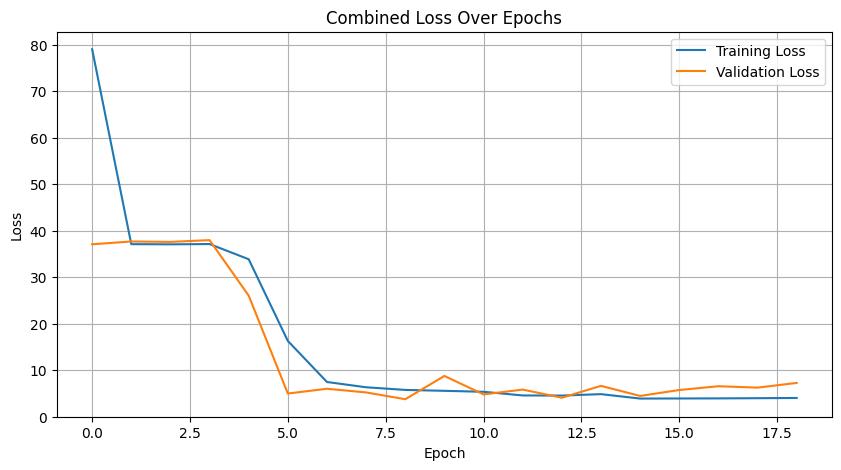

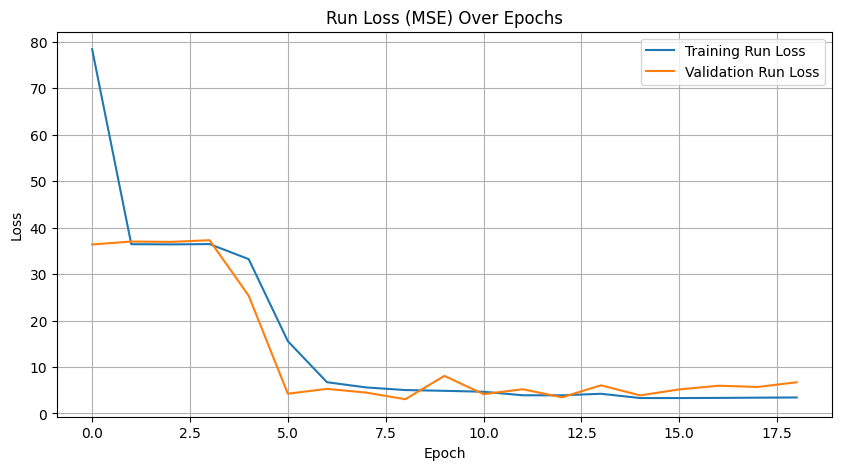

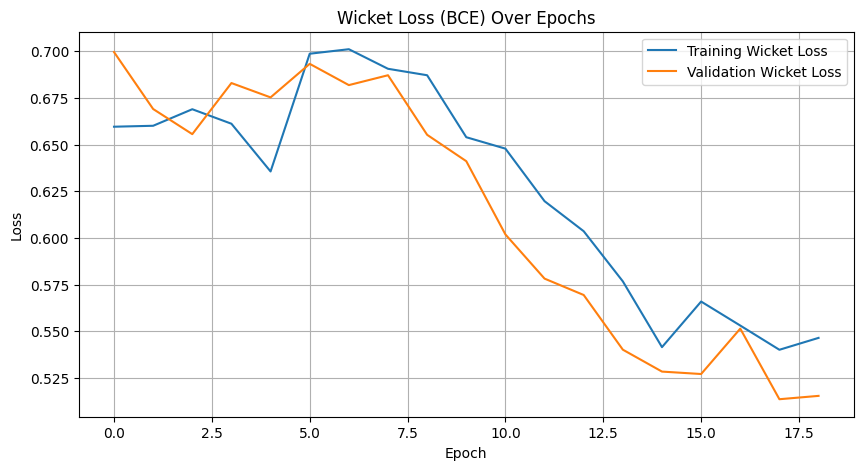

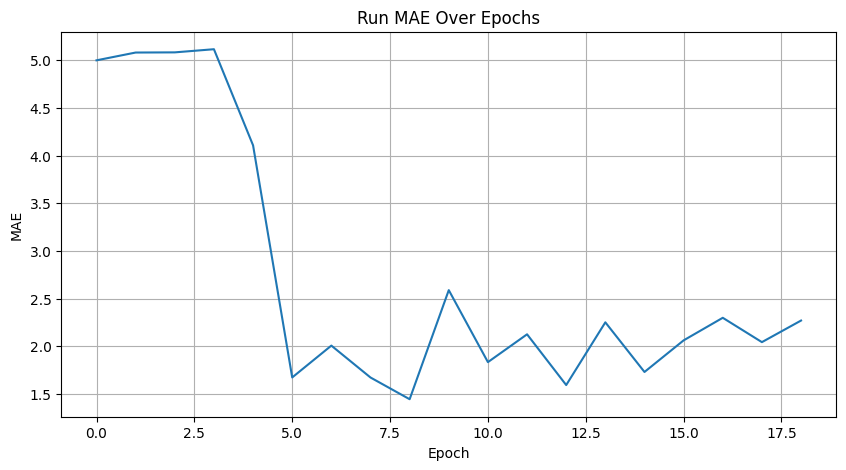

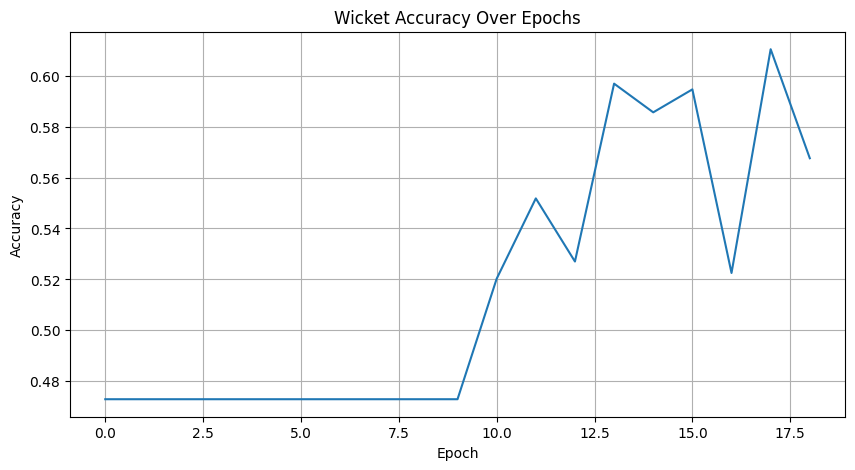

2025-05-07 11:06:44,009 - INFO - Model saved successfully with all components



Evaluation Results:
Overall Loss: 7.2292
Runs Accuracy (within ±0 runs): 0.00%
Runs MSE: 6.71
Wickets Accuracy: 41.67%


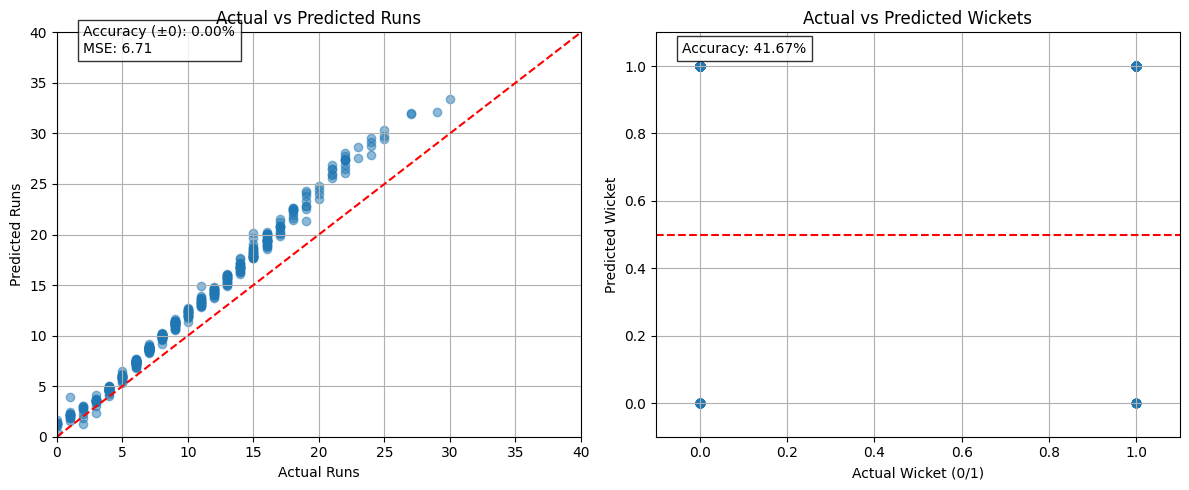


Evaluation Results:
Overall Test Loss: 7.2292
Runs Accuracy: 0.00%
Runs MSE: 6.71
Wickets Accuracy: 41.67%


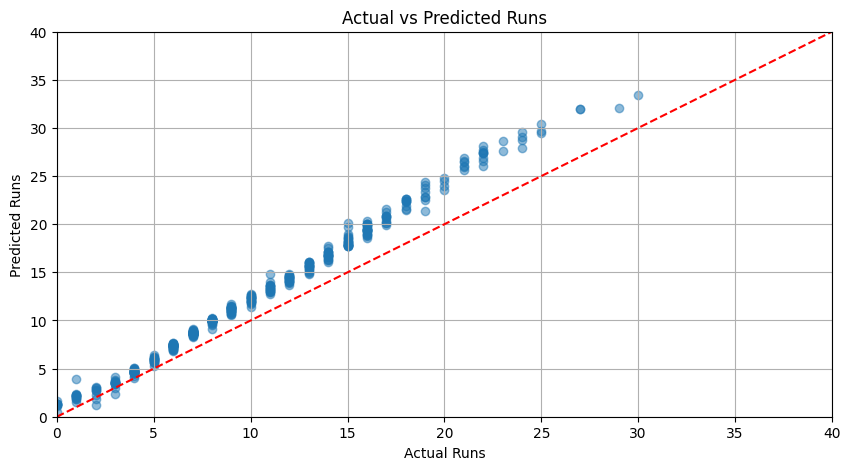

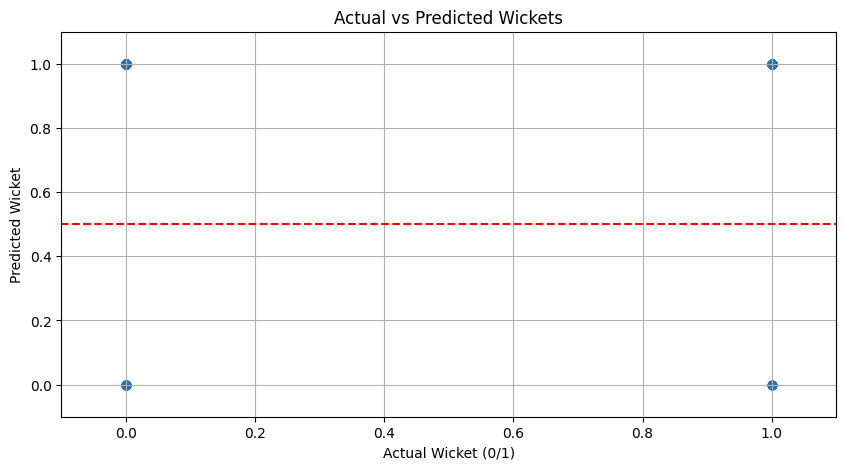

2025-05-07 11:06:45,586 - INFO - IPL Score Predictor execution completed successfully


In [423]:
# Example usage of the modularized functions
def main(use_cached_data=True, train_new_model=True, sequence_mode=True, save_split_data=True):
    """Main execution function for the IPL score prediction model.
    
    Args:
        use_cached_data: Whether to use previously processed data
        train_new_model: Whether to train a new model or load an existing one
        sequence_mode: Whether to use sequence mode for modeling
        save_split_data: Whether to save split data to separate folders
    """
    logger.info(f"Starting IPL Score Predictor with settings: use_cached_data={use_cached_data}, "
                f"train_new_model={train_new_model}, sequence_mode={sequence_mode}, "
                f"save_split_data={save_split_data}")
    
    # Data processing parameters
    input_path = 'cleaned_data/updated_over_by_over_data_set.csv'
    output_path = 'cleaned_data/weighted_run_rate_dataset.csv'
    
    # Load or process data
    if use_cached_data and os.path.exists(output_path):
        logger.info(f"Loading processed data from {output_path}")
        df = pd.read_csv(output_path)
        data = process_and_prepare_data(input_path, output_path, alpha=0.7, save_split_data=save_split_data)
    else:
        logger.info("Processing raw data")
        data = process_and_prepare_data(input_path, output_path, alpha=0.7, save_split_data=save_split_data)
    
    if data is None:
        logger.error("Failed to load or process data. Exiting.")
        return
    
    # Create train and test data dictionaries
    train_data = {
        'train_df': data['train_df'],
        'train_numerical_data': data['train_numerical_data'],
        'train_index_map': data['train_index_map']
    }
    
    test_data = {
        'test_df': data['test_df'],
        'test_numerical_data': data['test_numerical_data'],
        'test_index_map': data['test_index_map']
    }
    
    # Create dataloaders with the correct target columns
    target_cols = ['total_runs', 'is_wicket']
    train_loader, test_loader = create_dataloaders(train_data, test_data, batch_size=32, sequence=sequence_mode, target_cols=target_cols)
    
    # Calculate input size
    if sequence_mode:
        # In sequence mode, inspect the first batch
        for batch in train_loader:
            x_batch, _, _ = batch
            input_size = x_batch.shape[2]
            logger.info(f"Input size determined from batch: {input_size}")
            break
    else:
        # In single mode, add team features to numerical features
        input_size = len(data['numerical_features']) + 2  # +2 for batting_team and bowling_team
        logger.info(f"Input size calculated: {input_size}")
    
    # Model configuration
    model_config = {
        'model_params': {
            'input_size': input_size,
            'hidden_size': 64,
            'num_layers': 2,
            'dropout': 0.3,
            'output_size': 2,
            'temperature': 1.2
        },
        'training_params': {
            'learning_rate': 0.001,
            'batch_size': 32,
            'epochs': 32,
            'patience': 10,
            'sequence_mode': sequence_mode,
            'runs_weight': 1.0,
            'wicket_weight': 1
        },
        'feature_info': {
            'numerical_features': data['numerical_features'],
            'team_classes': list(data['team_encoder'].classes_) if 'team_encoder' in data else None
        },
        'date_created': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    # Create or load model
    if train_new_model:
        logger.info("Creating and training a new model")
        model = IPLScorePredictor(**model_config['model_params'])
        
        # Define loss function and optimizer
        criterion = CombinedIPLLoss(
            runs_weight=model_config['training_params']['runs_weight'],
            wicket_weight=model_config['training_params']['wicket_weight']
        )
        optimizer = optim.Adam(model.parameters(), lr=model_config['training_params']['learning_rate'])
        
        # Train the model
        model, history = train_model(
            model,
            train_loader, 
            test_loader,  # Using test_loader as validation for simplicity
            criterion, 
            optimizer,
            num_epochs=model_config['training_params']['epochs'],
            patience=model_config['training_params']['patience'],
            sequence=sequence_mode
        )
        
        # Plot training history
        plot_training_history(history)
        
        # Save model with configuration
        save_model_with_config(model, model_config, data['scaler'], data['team_encoder'])
    else:
        logger.info("Loading existing model")
        model, loaded_config = load_model_with_config(IPLScorePredictor)
        if model is None:
            logger.error("Failed to load model. Exiting.")
            return
        model_config = loaded_config
        
        # Create criterion with the same weights as during training
        criterion = CombinedIPLLoss(
            runs_weight=model_config['training_params']['runs_weight'],
            wicket_weight=model_config['training_params']['wicket_weight']
        )
    
    # Evaluate the model
    results = evaluate_model(model, test_loader, criterion, sequence=sequence_mode)
    
    # Print comprehensive evaluation results
    print("\nEvaluation Results:")
    print(f"Overall Test Loss: {results['loss']:.4f}")
    print(f"Runs Accuracy: {results['runs_accuracy']:.2%}")
    print(f"Runs MSE: {results['runs_mse']:.2f}")
    print(f"Wickets Accuracy: {results['wickets_accuracy']:.2%}")
    
    # Create results directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    
    MAX_RUNS_PER_OVER = 40  # Maximum possible runs in an over
    
    # Visualize run predictions vs actual
    plt.figure(figsize=(10, 5))
    plt.scatter(results['runs_true'], results['runs_pred'], alpha=0.5)
    plt.plot([0, MAX_RUNS_PER_OVER], [0, MAX_RUNS_PER_OVER], 'r--', label='Perfect Prediction')
    plt.title('Actual vs Predicted Runs')
    plt.xlabel('Actual Runs')
    plt.ylabel('Predicted Runs')
    plt.xlim(0, MAX_RUNS_PER_OVER)
    plt.ylim(0, MAX_RUNS_PER_OVER)
    plt.grid(True)
    plt.savefig(os.path.join('results', 'actual_vs_predicted_runs.png'))
    plt.show()
    
    # Visualize wicket predictions
    plt.figure(figsize=(10, 5))
    plt.scatter(results['wickets_true'], results['wickets_pred'], alpha=0.5)
    plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Boundary')
    plt.title('Actual vs Predicted Wickets')
    plt.xlabel('Actual Wicket (0/1)')
    plt.ylabel('Predicted Wicket')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.savefig(os.path.join('results', 'actual_vs_predicted_wickets.png'))
    plt.show()
    
    logger.info("IPL Score Predictor execution completed successfully")
    return model, results, criterion

# Run the main function
model, results, criterion = main(use_cached_data=True, train_new_model=True, sequence_mode=True, save_split_data=True)

## Prediction Function for New Matches

In [424]:
def predict_match(model, match_data, scaler, team_encoder, numerical_features, sequence=True):
    """Make predictions for a new match.
    
    Args:
        model: Trained PyTorch model
        match_data: DataFrame containing match data for prediction
        scaler: Fitted StandardScaler for numerical features
        team_encoder: Fitted LabelEncoder for team names
        numerical_features: List of numerical feature names
        sequence: Whether to use sequence mode for prediction
        
    Returns:
        Predicted scores
    """
    logger.info(f"Making predictions for new match data with {len(match_data)} overs")
    model.to(device)
    model.eval()
    
    # Process match data
    try:
        # Encode teams
        match_data['batting_team'] = team_encoder.transform(match_data['batting_team'])
        match_data['bowling_team'] = team_encoder.transform(match_data['bowling_team'])
        
        # Scale numerical features
        match_numerical = scaler.transform(match_data[numerical_features])
        
        # Prepare input features
        features = []
        for i, row in match_data.iterrows():
            numerical = torch.tensor(match_numerical[i], dtype=torch.float32)
            batting_team = torch.tensor([row['batting_team']], dtype=torch.float32)
            bowling_team = torch.tensor([row['bowling_team']], dtype=torch.float32)
            combined = torch.cat([numerical, batting_team, bowling_team])
            features.append(combined)
        
        if sequence:
            # Stack features to create sequence
            features = torch.stack(features).unsqueeze(0).to(device)  # Add batch dimension
            seq_length = torch.tensor([len(features[0])], dtype=torch.int32).to(device)
            
            # Make prediction
            with torch.no_grad():
                outputs = model(features, seq_length)
                run_prediction = outputs[0, 0].cpu().item()
                wicket_probability = torch.sigmoid(outputs[0, 1]).cpu().item()
        else:
            # Make prediction for each over
            run_predictions = []
            wicket_probabilities = []
            with torch.no_grad():
                for feature in features:
                    feature = feature.unsqueeze(0).to(device)  # Add batch dimension
                    outputs = model(feature)
                    run_predictions.append(outputs[0, 0].cpu().item())
                    wicket_probabilities.append(torch.sigmoid(outputs[0, 1]).cpu().item())
            run_prediction = run_predictions[-1]  # Use prediction from last over
            wicket_probability = wicket_probabilities[-1]
        
        # Round predictions for display
        predicted_runs = max(0, round(run_prediction))  # Runs can't be negative
        wicket_binary = 1 if wicket_probability > 0.8 else 0
        
        logger.info(f"Prediction complete: {predicted_runs} runs, wicket probability: {wicket_probability:.2%}")
        return {
            'predicted_runs': predicted_runs,
            'wicket_probability': wicket_probability,
            'wicket_binary': wicket_binary,
            'raw_run_prediction': run_prediction
        }
        
    except Exception as e:
        logger.error(f"Error making prediction: {e}")
        return None